<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Insurance_MYV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,  # Added for Matthews Correlation
    roc_auc_score,      # Added for AUC score
    accuracy_score      # Added for test accuracy
)


- Imports necessary libraries for data manipulation (pandas, numpy)
- Machine learning tools from scikit-learn
- SMOTE for handling imbalanced data

In [2]:
# Step 1: Load the dataset
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify file path
file_path = '/content/drive/My Drive/telematics_syn.csv'

# Import pandas (assuming you want to use it to read the CSV)
import pandas as pd

# Read the CSV file
data = pd.read_csv(file_path)

# Step 2: Explore the data
print(data.head())
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Display basic statistics
print(data.describe())

Mounted at /content/drive
   Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   

   Left.turn.intensity11  Left

- Data Loading:

    - Mounts Google Drive
    - Reads the telematics dataset from CSV


- Data Exploration:

    - Shows first few rows with head()
    - Displays dataset info and statistics
    - Checks for missing values

In [3]:
# Separate features and target
X = data.drop(['NB_Claim', 'AMT_Claim'], axis=1)
y = (data['NB_Claim'] > 0).astype(int)  # Convert to binary (0 for no claim, 1 for claim)

In [4]:
# Check class balance
class_counts = y.value_counts()
print("Class distribution:")
print(class_counts)
print(f"Class balance ratio: {class_counts[0] / class_counts[1]:.2f}")

Class distribution:
NB_Claim
0    95728
1     4272
Name: count, dtype: int64
Class balance ratio: 22.41


- Separates features (X) and target (y)
- Converts claims to binary classification (0 for no claim, 1 for claim)
- Checks class distribution and imbalance

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Insured.sex', 'Marital', 'Car.use', 'Region']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

- Splits data into training and test sets
- Creates preprocessor for both numeric and categorical features
- Standardizes numeric features
- One-hot encodes categorical features

In [7]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [8]:
# Create Random Forest classifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)


In [9]:
# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

In [10]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Duration', 'Insured.age', 'Car.age', 'Credit.score',
       'Annual.miles.drive', 'Years.noclaims', 'Territory',
       'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.mon',
       'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 'Pct.drive.fri',
       'Pct.drive.sat', 'Pct.drive.sun', 'P...
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity11', 'Right.turn.intensity12'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Insured.sex', 'Marital',
                                                   'Car.use', 'Region'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

- Computes class weights to handle imbalanced data
- Creates Random Forest classifier with balanced weights
- Builds pipeline combining preprocessor and classifier
- Trains the model

In [15]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate probabilities for AUC score
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate and print all metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# New metrics
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nAdditional Metrics:")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"AUC Score: {auc:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Feature importance analysis
feature_importance = pipeline.named_steps['classifier'].feature_importances_
feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
                preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

indices = np.argsort(feature_importance)[::-1]

print("\nTop 20 Feature ranking:")
for f in range(min(20, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19130
           1       0.97      0.26      0.41       870

    accuracy                           0.97     20000
   macro avg       0.97      0.63      0.70     20000
weighted avg       0.97      0.97      0.96     20000


Confusion Matrix:
[[19122     8]
 [  641   229]]

Additional Metrics:
Matthews Correlation Coefficient: 0.495
AUC Score: 0.938
Test Accuracy: 0.968

Cross-validation scores: [0.968   0.9677  0.96725 0.96695 0.9692 ]
Mean CV score: 0.968 (+/- 0.002)

Top 20 Feature ranking:
1. Total.miles.driven (0.103526)
2. Annual.pct.driven (0.092099)
3. Duration (0.033678)
4. Credit.score (0.032826)
5. Pct.drive.2hrs (0.030017)
6. Avgdays.week (0.030016)
7. Pct.drive.thr (0.028129)
8. Pct.drive.rush am (0.027172)
9. Pct.drive.rush pm (0.024612)
10. Pct.drive.wed (0.024558)
11. Pct.drive.mon (0.024377)
12. Pct.drive.tue (0.023702)
13. Pct.drive.fri (0.023

## Model Evaluation:

- Makes predictions on test set
- Calculates various metrics:

    - Classification report (precision, recall, F1-score)
    - Confusion matrix

    - Matthews Correlation Coefficient (MCC): Measures correlation between predicted and actual values
    - AUC Score: Area Under the ROC Curve
    - Test Accuracy: Simple accuracy score




- Performs cross-validation
- Analyzes feature importance

In [16]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.5 MB/s eta 0:00:00


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [18]:
# Select top 20 features based on the provided ranking
top_features = [
    'Total.miles.driven', 'Annual.pct.driven', 'Duration', 'Credit.score',
    'Pct.drive.2hrs', 'Avgdays.week', 'Pct.drive.thr', 'Pct.drive.rush am',
    'Pct.drive.rush pm', 'Pct.drive.wed', 'Pct.drive.mon', 'Pct.drive.tue',
    'Pct.drive.fri', 'Brake.06miles', 'Pct.drive.sat', 'Pct.drive.sun',
    'Car.age', 'Accel.06miles', 'Years.noclaims', 'Left.turn.intensity09'
]

In [19]:
# Prepare the data
X = data[top_features]
y = (data['NB_Claim'] > 0).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

In [22]:
# Initialize and train TabNet
tabnet_model = TabNetClassifier(
    n_d=8, n_a=8, n_steps=3,
    gamma=1.3, n_independent=2, n_shared=2,
    cat_idxs=[], cat_dims=[],
    cat_emb_dim=1, optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    lambda_sparse=1e-3, momentum=0.3, clip_value=2.,
    device_name='auto'
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [23]:
tabnet_model.fit(
    X_train_tensor.numpy(), y_train_tensor.numpy(),
    eval_set=[(X_test_tensor.numpy(), y_test_tensor.numpy())],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.18476 | val_0_auc: 0.76645 |  0:00:05s
epoch 1  | loss: 0.15592 | val_0_auc: 0.77502 |  0:00:09s
epoch 2  | loss: 0.15475 | val_0_auc: 0.78037 |  0:00:12s
epoch 3  | loss: 0.15396 | val_0_auc: 0.78723 |  0:00:15s
epoch 4  | loss: 0.15322 | val_0_auc: 0.78997 |  0:00:20s
epoch 5  | loss: 0.15155 | val_0_auc: 0.79364 |  0:00:23s
epoch 6  | loss: 0.15093 | val_0_auc: 0.79293 |  0:00:27s
epoch 7  | loss: 0.14993 | val_0_auc: 0.79093 |  0:00:30s
epoch 8  | loss: 0.1509  | val_0_auc: 0.78905 |  0:00:34s
epoch 9  | loss: 0.15087 | val_0_auc: 0.78983 |  0:00:38s
epoch 10 | loss: 0.1501  | val_0_auc: 0.79775 |  0:00:41s
epoch 11 | loss: 0.14953 | val_0_auc: 0.79415 |  0:00:46s
epoch 12 | loss: 0.14887 | val_0_auc: 0.79751 |  0:00:49s
epoch 13 | loss: 0.14989 | val_0_auc: 0.79007 |  0:00:53s
epoch 14 | loss: 0.14928 | val_0_auc: 0.79409 |  0:00:58s
epoch 15 | loss: 0.14901 | val_0_auc: 0.79624 |  0:01:02s
epoch 16 | loss: 0.14865 | val_0_auc: 0.80019 |  0:01:06s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# Automatically detect device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#The TabNetClassifier does not have a to() method, instead it sets the device during initialization
#Remove or comment out the following line:
#tabnet_model.to(device)

# Instead, ensure you specified the correct device when you initialized the model
#If you are still encountering issues and your device is set to 'auto', you can set it using the device param
#tabnet_model = TabNetClassifier(device_name=device) # Replace device with 'cuda' or 'cpu' as needed

# Convert data to PyTorch tensors and move to the same device as the model
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Extract learned features using the model's forward function to get embeddings
with torch.no_grad():
    # Make sure network method takes device into account
    # Assuming the first element of the tuple is the desired output
    output = tabnet_model.network(X_train_tensor.to(tabnet_model.device))
    train_features = output[0].cpu().numpy()  # Access the first element and move to CPU for numpy

    output = tabnet_model.network(X_test_tensor.to(tabnet_model.device))
    test_features = output[0].cpu().numpy() # Access the first element and move to CPU for numpy


# Train SVM on the extracted features
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(train_features, y_train)

# Make predictions
y_pred = svm_model.predict(test_features)
y_pred_proba = svm_model.predict_proba(test_features)[:, 1]

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.3f}")

# Feature importance from TabNet
feat_importances = tabnet_model.feature_importances_
feat_importance_dict = dict(zip(top_features, feat_importances))
sorted_feat_importances = sorted(feat_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nTabNet Feature Importances:")
for feat, importance in sorted_feat_importances:
    print(f"{feat}: {importance:.6f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     19146
           1       0.10      0.78      0.18       854

    accuracy                           0.70     20000
   macro avg       0.54      0.74      0.50     20000
weighted avg       0.95      0.70      0.79     20000


Confusion Matrix:
[[13362  5784]
 [  187   667]]

ROC AUC Score: 0.808

TabNet Feature Importances:
Duration: 0.285232
Total.miles.driven: 0.184323
Avgdays.week: 0.164837
Annual.pct.driven: 0.113711
Brake.06miles: 0.065162
Pct.drive.sat: 0.038803
Years.noclaims: 0.033412
Credit.score: 0.031820
Pct.drive.2hrs: 0.023103
Pct.drive.sun: 0.021995
Pct.drive.tue: 0.014535
Pct.drive.rush am: 0.013778
Car.age: 0.006937
Pct.drive.mon: 0.002280
Accel.06miles: 0.000035
Pct.drive.rush pm: 0.000033
Pct.drive.thr: 0.000003
Pct.drive.fri: 0.000001
Pct.drive.wed: 0.000001
Left.turn.intensity09: 0.000000


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.18476 | val_0_auc: 0.76645 |  0:00:03s
epoch 1  | loss: 0.15592 | val_0_auc: 0.77502 |  0:00:07s
epoch 2  | loss: 0.15475 | val_0_auc: 0.78037 |  0:00:11s
epoch 3  | loss: 0.15396 | val_0_auc: 0.78723 |  0:00:14s
epoch 4  | loss: 0.15322 | val_0_auc: 0.78997 |  0:00:18s
epoch 5  | loss: 0.15155 | val_0_auc: 0.79364 |  0:00:22s
epoch 6  | loss: 0.15093 | val_0_auc: 0.79293 |  0:00:26s
epoch 7  | loss: 0.14993 | val_0_auc: 0.79093 |  0:00:29s
epoch 8  | loss: 0.1509  | val_0_auc: 0.78905 |  0:00:33s
epoch 9  | loss: 0.15087 | val_0_auc: 0.78983 |  0:00:37s
epoch 10 | loss: 0.1501  | val_0_auc: 0.79775 |  0:00:40s
epoch 11 | loss: 0.14953 | val_0_auc: 0.79415 |  0:00:44s
epoch 12 | loss: 0.14887 | val_0_auc: 0.79751 |  0:00:48s
epoch 13 | loss: 0.14989 | val_0_auc: 0.79007 |  0:00:51s
epoch 14 | loss: 0.14928 | val_0_auc: 0.79409 |  0:00:55s
epoch 15 | loss: 0.14901 | val_0_auc: 0.79624 |  0:00:58s
epoch 16 | loss: 0.14865 | val_0_auc: 0.80019 |  0:01:03s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Model Performance Metrics:
--------------------------------------------------
Test Accuracy: 0.773
Matthews Correlation Coefficient: 0.242
ROC AUC Score: 0.816

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     19146
           1       0.13      0.74      0.22       854

    accuracy                           0.77     20000
   macro avg       0.56      0.76      0.54     20000
weighted avg       0.95      0.77      0.84     20000


Confusion Matrix:
[[14837  4309]
 [  221   633]]


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


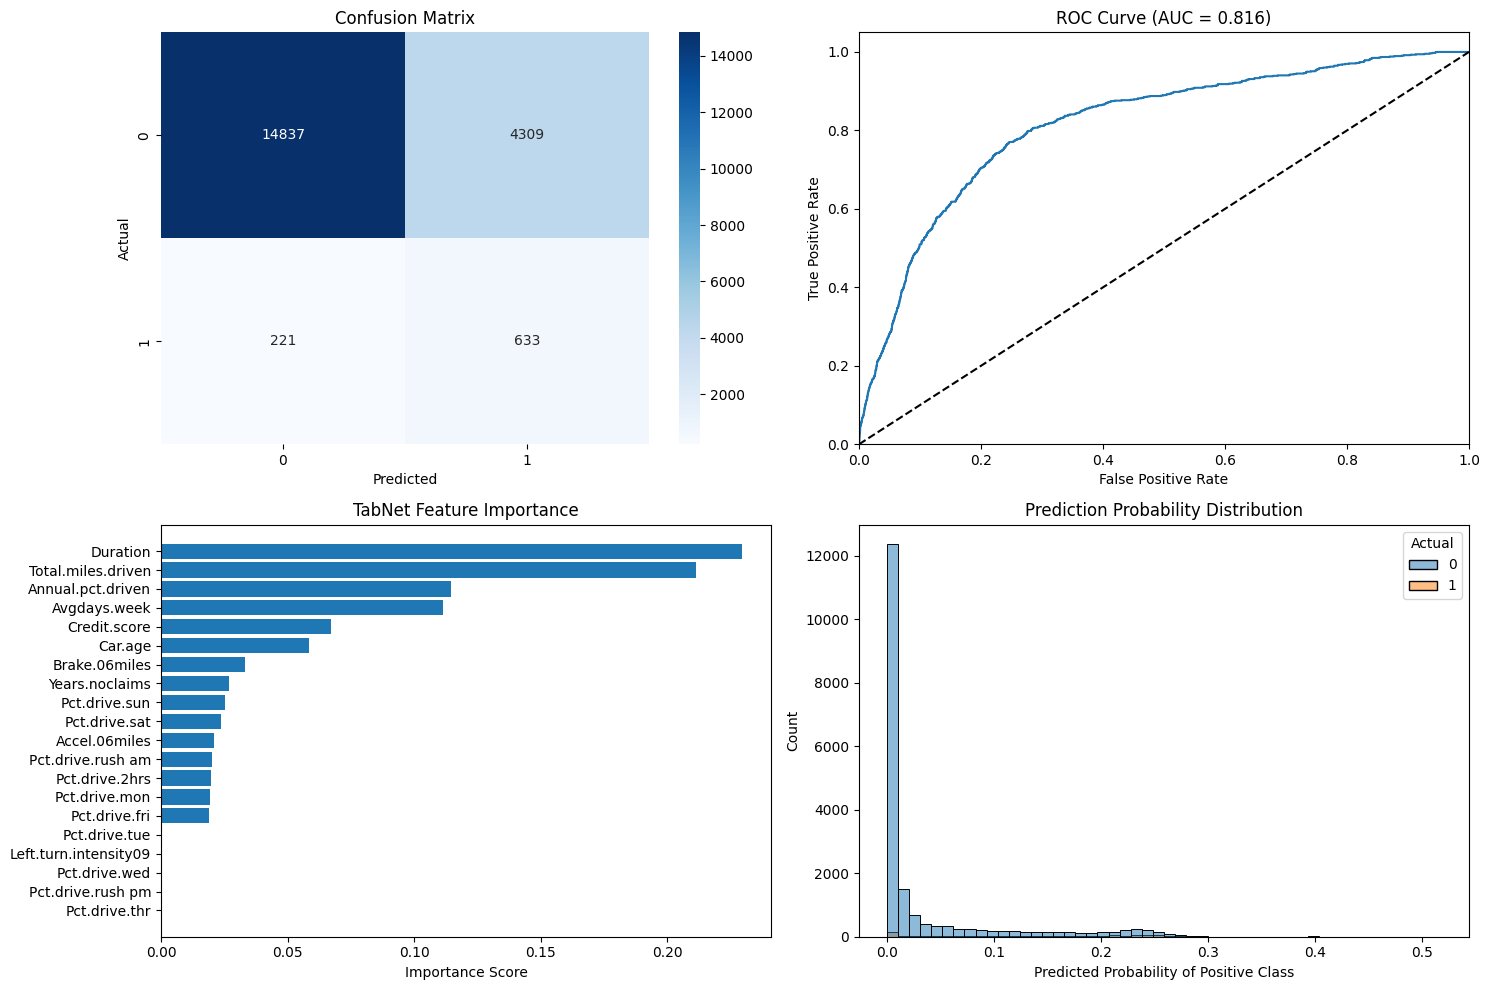


TabNet Feature Importances:
                  Feature    Importance
2                Duration  2.293648e-01
0      Total.miles.driven  2.114111e-01
1       Annual.pct.driven  1.143686e-01
5            Avgdays.week  1.113107e-01
3            Credit.score  6.707104e-02
16                Car.age  5.853172e-02
13          Brake.06miles  3.307807e-02
18         Years.noclaims  2.677336e-02
15          Pct.drive.sun  2.517574e-02
14          Pct.drive.sat  2.350950e-02
17          Accel.06miles  2.089833e-02
7       Pct.drive.rush am  2.033423e-02
4          Pct.drive.2hrs  1.977351e-02
10          Pct.drive.mon  1.941784e-02
12          Pct.drive.fri  1.898156e-02
11          Pct.drive.tue  8.525227e-11
8       Pct.drive.rush pm  0.000000e+00
9           Pct.drive.wed  0.000000e+00
6           Pct.drive.thr  0.000000e+00
19  Left.turn.intensity09  0.000000e+00


In [24]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    accuracy_score,
    roc_curve
)
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 20 features
top_features = [
    'Total.miles.driven', 'Annual.pct.driven', 'Duration', 'Credit.score',
    'Pct.drive.2hrs', 'Avgdays.week', 'Pct.drive.thr', 'Pct.drive.rush am',
    'Pct.drive.rush pm', 'Pct.drive.wed', 'Pct.drive.mon', 'Pct.drive.tue',
    'Pct.drive.fri', 'Brake.06miles', 'Pct.drive.sat', 'Pct.drive.sun',
    'Car.age', 'Accel.06miles', 'Years.noclaims', 'Left.turn.intensity09'
]

# Prepare the data
X = data[top_features]
y = (data['NB_Claim'] > 0).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# Initialize and train TabNet
tabnet_model = TabNetClassifier(
    n_d=8, n_a=8, n_steps=3,
    gamma=1.3, n_independent=2, n_shared=2,
    cat_idxs=[], cat_dims=[],
    cat_emb_dim=1, optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    lambda_sparse=1e-3, momentum=0.3, clip_value=2.,
    device_name='auto'
)

# Train TabNet
tabnet_model.fit(
    X_train_tensor.numpy(), y_train_tensor.numpy(),
    eval_set=[(X_test_tensor.numpy(), y_test_tensor.numpy())],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Extract learned features
with torch.no_grad():
    output = tabnet_model.network(X_train_tensor.to(tabnet_model.device))
    train_features = output[0].cpu().numpy()

    output = tabnet_model.network(X_test_tensor.to(tabnet_model.device))
    test_features = output[0].cpu().numpy()

# Train SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(train_features, y_train)

# Make predictions
y_pred = svm_model.predict(test_features)
y_pred_proba = svm_model.predict_proba(test_features)[:, 1]

# Calculate metrics
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print all metrics
print("\nModel Performance Metrics:")
print("-" * 50)
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"ROC AUC Score: {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(conf_matrix)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title(f'ROC Curve (AUC = {auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 3. Feature Importance Plot
plt.subplot(2, 2, 3)
feat_importances = tabnet_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': feat_importances
}).sort_values('Importance', ascending=True)

plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.title('TabNet Feature Importance')
plt.xlabel('Importance Score')

# 4. Prediction Distribution
plt.subplot(2, 2, 4)
sns.histplot(data=pd.DataFrame({
    'Probability': y_pred_proba,
    'Actual': y_test
}), x='Probability', hue='Actual', bins=50)
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Save feature importances to DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': feat_importances
}).sort_values('Importance', ascending=False)

print("\nTabNet Feature Importances:")
print(feat_importance_df)